# Modelling a COPD ward

The simplest model using the data available to us is an $M|M|c$ queueing model. In this model, the following assumptions are made:

1. Interarrival and service times of patients are each exponential with some mean.
2. There are $c$ servers available to arriving patients at a single node representing the overall resource availability.
4. There is a queue capacity of 100 patients.
3. A first-in first-out service policy is implemented.

### Determining the distributions

#### Arrivals

Each class of patient (by treatment type) has its own arrival distribution. This is found by grouping the data by treatment and finding the mean arrival rate $\lambda_g$ from the reciprocal of the mean interarrival times for group $g$.

#### Services (derived from responses)

Technically, length of stay (LOS) is the total time spent in the system, i.e. the response time. Without full details of process order and idle periods during a spell, we will consider the mean service time, $\frac{1}{\mu}$, to be proportional to the mean total system time, $\frac{1}{\phi}$, such that:

$$ \mu = p \phi $$

where $p \in (0, 1]$ is some parameter to be determined along with the number of servers, $c$.

##### Thoughts on wait times and discounting responses

Under the $M|M|c$ framework, we suppose each patient enters the system, waits once and is serviced once. We estimate the average wait time over a period $t$ using an indirect estimator [[Kim2013]](http://www.columbia.edu/~ww2040/Kim_Whitt_PEIS_2013.pdf) given by:

$$ \overline W(t) = \frac{\overline L(t)}{\overline \lambda (t)} $$

where $\overline L(t)$ is the average size of the system over a period $t$, and $\overline \lambda (t)$ is the arrival rate over a period $t$.

This value of $\overline W(t)$ is calculated for each group and subtracted from the mean response time to give an estimate for the mean service time $\frac{1}{\mu}$.

In [1]:
import itertools as it
from collections import defaultdict

import ciw
from ciw.dists import Exponential
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import special, stats

%matplotlib inline
plt.style.use("seaborn-colorblind")


In [2]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv", parse_dates=["admission_date", "discharge_date"]
)

copd = copd[copd["admission_date"] > "2014-06-01"]


The following code gets the number of patients in the hospital system on a given date.

```python
def get_n_patients(data, date):

    patients_in_system_at_date = (
        (data["admission_date"] <= date)
        & (date <= data["discharge_date"])
    )

    return len(data[patients_in_system_at_date])


get_parts = lambda x: (x.year, x.month, x.day)
year, month, day = get_parts(copd["admission_date"].min())
start_date = pd.to_datetime(f"{year}-{month}-{day}")

year, month, day = get_parts(copd["discharge_date"].max())
end_date = pd.to_datetime(f"{year}-{month}-{day + 1}")
system_size = pd.DataFrame(
    {"date": pd.date_range(start=start_date, end=end_date, freq="d")}
)

for intervention, data in copd.groupby("intervention"):
    system_size[intervention] = system_size["date"].apply(lambda date: get_n_patients(data, date))
```

In [18]:
def plot_distribution(data, scale, intervention, label, dist):

    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

    _, p_value = stats.kstest(data, dist.cdf, (0, scale))
    xs = np.linspace(0, data.max(), 1000)

    ax.plot(xs, dist.pdf(xs, 0, scale), label=f"Exp(rate={round(1 / scale, 2)})")
    ax.hist(data, density=True, alpha=0.5, bins=40, label="Observed data")
    ax.annotate(
        s=f"p-value={p_value:.3e}",
        xy=(ax.get_xlim()[1] * 0.75, ax.get_ylim()[1] * 0.75),
    )

    ax.set_ylabel("Likelihood of observation")
    ax.set_xlabel(label)
    ax.set_title(intervention)
    ax.legend()


def get_times(data):

    return data.dt.total_seconds().div(24 * 60 * 60, fill_value=0)


def get_queue_params(dataset, props, dist=stats.expon):

    queue_params = defaultdict(dict)
    for (intervention, data), service_prop in zip(
        dataset.groupby("intervention"), props
    ):

        inter_arrivals = (
            data.set_index("admission_date").sort_index().index.to_series().diff()
        )
        interarrival_times = get_times(inter_arrivals)
        lambda_ = np.mean(interarrival_times)

        system_exits = data["discharge_date"] - data["admission_date"]
        system_times = get_times(system_exits)
        mean_system_time = np.mean(system_times)
        mu_estimate = mean_system_time * service_prop

        queue_params[intervention] = {
            "arrival": 1 / lambda_,
            "service": 1 / mu_estimate,
        }

    return queue_params


In [19]:
@dask.delayed
def run_multiple_class_trial(data, props, num_servers, seed):

    ciw.seed(seed)
    queue_params = get_queue_params(copd, props)

    N = ciw.create_network(
        arrival_distributions={
            f"Class {i}": [Exponential(params["arrival"])]
            for i, params in enumerate(queue_params.values())
        },
        service_distributions={
            f"Class {i}": [Exponential(params["service"])]
            for i, params in enumerate(queue_params.values())
        },
        number_of_servers=[num_servers],
        queue_capacities=[100],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(365 * 30)

    records = Q.get_all_records()
    results = pd.DataFrame(
        [r for r in records if r.arrival_date > 365 * 10 and r.arrival_date < 365 * 20]
    )

    results["service_prop"] = props[results["customer_class"] - 1]
    results["num_servers"] = num_servers
    results["seed"] = seed

    return results


@dask.delayed
def run_single_class_trial(data, service_prop, num_servers, seed):

    ciw.seed(seed)

    inter_arrivals = (
        data.set_index("admission_date").sort_index().index.to_series().diff()
    )
    interarrival_times = get_times(inter_arrivals)
    lambda_ = np.mean(interarrival_times)

    system_exits = data["discharge_date"] - data["admission_date"]
    system_times = get_times(system_exits)
    mean_system_time = np.mean(system_times)
    mu_estimate = mean_system_time * service_prop

    N = ciw.create_network(
        arrival_distributions=[Exponential(1 / lambda_)],
        service_distributions=[Exponential(1 / mu_estimate)],
        number_of_servers=[num_servers],
        queue_capacities=[100],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(365 * 30)

    records = Q.get_all_records()
    results = pd.DataFrame(
        [r for r in records if r.arrival_date > 365 * 10 and r.arrival_date < 365 * 20]
    )

    results["service_prop"] = service_prop
    results["num_servers"] = num_servers
    results["seed"] = seed

    return results


In [21]:
# tasks = (
#     run_multiple_class_trial(copd, np.round(props, 2), num_servers, seed=0)
#     for props, num_servers in it.product(
#         it.product(np.linspace(0.5, 1, 6), repeat=copd["intervention"].nunique()), range(10, 21)
#     )
# )

# with ProgressBar():
#     dfs = dask.compute(*tasks, scheduler="processes", num_workers=6)

# df = pd.concat(dfs)
# df["total_time"] = df["exit_date"] - df["arrival_date"]

# df.head()


In [5]:
tasks = (
    run_single_class_trial(copd, round(service_prop, 2), num_servers, seed=0)
    for service_prop, num_servers in it.product(np.linspace(0.5, 1, 6), range(10, 21))
)

with ProgressBar():
    dfs = dask.compute(*tasks, scheduler="processes", num_workers=6)

df = pd.concat(dfs)
df["total_time"] = df["exit_date"] - df["arrival_date"]

df.head()


[########################################] | 100% Completed |  2min 24.6s


,id_number,customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,service_prop,num_servers,seed,total_time
0,13918,0,1,3650.900344,38.745162,3689.645505,0.864221,3690.509726,0.0,3690.509726,-1,109,106,0.5,10,0,39.609383
1,13922,0,1,3652.157524,39.866872,3692.024396,0.180341,3692.204737,0.0,3692.204737,-1,107,107,0.5,10,0,40.047213
2,13919,0,1,3651.117907,38.567717,3689.685623,2.999244,3692.684868,0.0,3692.684868,-1,108,106,0.5,10,0,41.566961
3,13921,0,1,3652.100787,38.884267,3690.985053,1.956510,3692.941564,0.0,3692.941564,-1,106,107,0.5,10,0,40.840777
4,13917,0,1,3650.734135,38.669953,3689.404088,3.746412,3693.150500,0.0,3693.150500,-1,108,105,0.5,10,0,42.416365


In [22]:
data = (
    df.groupby(["service_prop", "num_servers"])["total_time"]
    .median()
    .values.reshape(df["service_prop"].nunique(), df["num_servers"].nunique())
)


Text(0, 0.5, 'Service proportion')

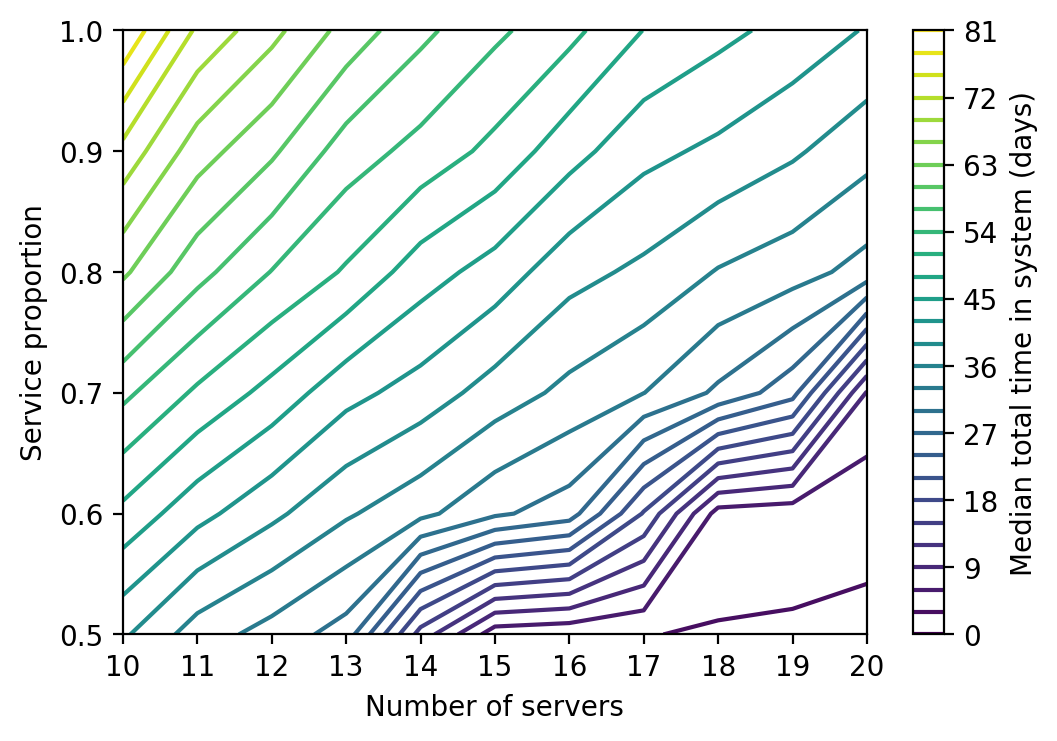

In [25]:
fig, ax = plt.subplots(dpi=200)

c = ax.contour(data, levels=30)
fig.colorbar(c, label="Median total time in system (days)")

ax.set_xticks(range(df["num_servers"].nunique()))
ax.set_xticklabels(df["num_servers"].unique())
ax.set_xlabel("Number of servers")

ax.set_yticklabels(np.round(df["service_prop"].unique(), 2))
ax.set_ylabel("Service proportion")


In [26]:
copd["system_time"] = get_times(copd["discharge_date"] - copd["admission_date"])


In [9]:
distances = {}
for (num_servers, service_prop), values in df.groupby(["num_servers", "service_prop"])[
    "total_time"
]:
    distance = stats.wasserstein_distance(values, copd["system_time"])
    distances[(num_servers, service_prop)] = distance


In [10]:
distance_df = pd.Series(distances).reset_index()
distance_df.columns = ["num_servers", "service_prop", "distance"]
pivot = distance_df.pivot(
    index="num_servers", columns="service_prop", values="distance"
)
pivot


service_prop,0.5,0.6,0.7,0.8,0.9,1.0
num_servers,,,,,,
10,33.227638,40.805232,48.467794,57.070407,64.798729,74.413430
11,28.620585,36.656359,44.169318,51.700386,57.972989,65.483360
12,25.782985,33.539900,40.851617,47.849422,54.552631,61.175914
13,22.815649,30.442064,36.856094,44.757328,49.519389,56.001728
14,8.268869,27.860695,34.644794,40.495742,47.001502,51.875578
15,2.805890,24.537183,31.715349,37.898136,44.290321,48.816968
16,2.943674,21.942870,29.495826,34.178629,40.423463,46.023964
17,3.328628,11.080186,27.139063,32.698405,37.147549,42.357832
18,3.528712,2.639504,23.454237,30.083668,35.770563,40.385263


In [11]:
idx = distance_df["distance"].values.argmin()
best = distance_df.iloc[idx]

c, p = int(best["num_servers"]), best["service_prop"]

best_df = df[(df["num_servers"] == c) & (df["service_prop"] == p)]
best_df


,id_number,customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,service_prop,num_servers,seed,total_time
0,13784,0,1,3650.251189,0.541484,3650.792673,0.421307,3651.213981,0.0,3651.213981,-1,20,19,0.6,19,0,0.962791
1,13786,0,1,3651.205488,0.008493,3651.213981,0.858794,3652.072775,0.0,3652.072775,-1,19,17,0.6,19,0,0.867287
2,13788,0,1,3652.266082,0.000000,3652.266082,0.140756,3652.406838,0.0,3652.406838,-1,16,16,0.6,19,0,0.140756
3,13787,0,1,3651.727971,0.000000,3651.727971,1.008579,3652.736550,0.0,3652.736550,-1,17,15,0.6,19,0,1.008579
4,13789,0,1,3652.552116,0.000000,3652.552116,0.766236,3653.318352,0.0,3653.318352,-1,15,17,0.6,19,0,0.766236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13970,27743,0,1,7296.300304,0.000000,7296.300304,8.727831,7305.028134,0.0,7305.028134,-1,17,14,0.6,19,0,8.727831
13971,27739,0,1,7296.157505,0.000000,7296.157505,9.508097,7305.665603,0.0,7305.665603,-1,14,12,0.6,19,0,9.508097
13972,27744,0,1,7296.396587,0.000000,7296.396587,9.506078,7305.902665,0.0,7305.902665,-1,18,12,0.6,19,0,9.506078
13973,27741,0,1,7296.227922,0.000000,7296.227922,10.321913,7306.549835,0.0,7306.549835,-1,16,11,0.6,19,0,10.321913


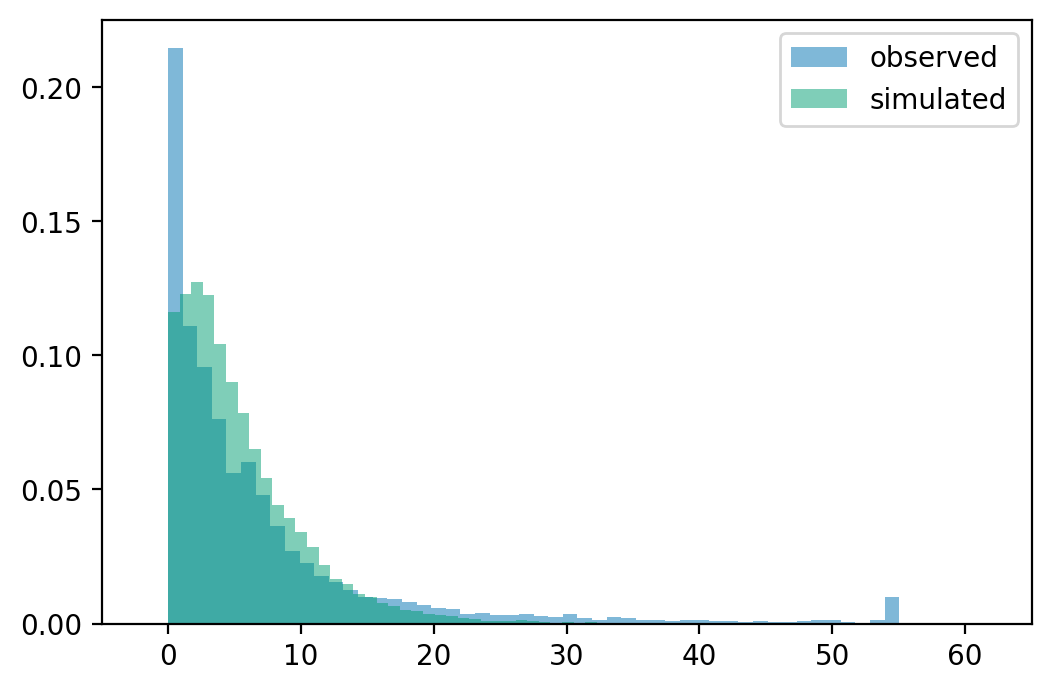

In [12]:
fig, ax = plt.subplots(dpi=200)

upper = np.percentile(copd["system_time"], 99)

ax.hist(
    copd["system_time"].clip(upper=upper),
    bins=50,
    alpha=0.5,
    density=True,
    label="observed data",
)
ax.hist(best_df["total_time"], bins=50, alpha=0.5, density=True, label="simulated data")

ax.set_xlim(-5, 65)
ax.legend()
